<a href="https://colab.research.google.com/github/daniui/Machine-Learning-Project/blob/main/Analisis%20Data%20Tidak%20Terstruktur/(wandb)Hilmy_Rahmadani_Document_classification_Bert_2206810490.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hilmy Rahmadani / 2206810490**


https://www.kaggle.com/code/merishnasuwal/document-classification-using-bert/notebook


In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf

import datetime
from datetime import datetime
import transformers
from transformers import BertTokenizer
import tensorflow_hub as hub


#420957f732fd2695734cb5feb1279013

##Read Training dataset

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: danskuy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification


In [ ]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = '/content/bbc-full-text-document-classification'
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

Kode ini membaca semua file teks dalam subdirektori dari dataset bbc-full-text-document-classification, mengabaikan README.TXT, lalu menyimpan informasi tentang direktori, nama file, label (kategori subdirektori), judul (baris pertama setiap file), dan isi teks dalam daftar terpisah.

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)),
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df

text  label
0       France have brought flanker Serge Betsen bac...  sport
1       Carlos Moya described Spain's Davis Cup vict...  sport
2       Second seed Andre Agassi suffered a comprehe...  sport
3       Scotland manager Walter Smith has given his ...  sport
4       Juninho's agent has confirmed that the playe...  sport
...                                                 ...    ...
4445    A team of US researchers has shown that cont...   tech
4446    Civil liberties group the Electronic Frontie...   tech
4447    Mobile phones are still enjoying a boom time...   tech
4448    First it was the humble home video, then it ...   tech
4449    Robots are learning lessons on "robotiquette...   tech

[4450 rows x 2 columns]

Kode ini membuat DataFrame dari daftar yang berisi informasi direktori, nama file, judul, teks, dan label, lalu menyimpan hanya kolom 'text' dan 'label' dalam DataFrame baru sebelum menampilkannya.

In [ ]:
print(f"dataset shape: {df.shape}")
print(f"dataset missing values: {df.isna().sum()}")
print(f"label unique values: {pd.unique(df.label)}")

dataset shape: (4450, 2)
dataset missing values: text     0
label    0
dtype: int64
label unique values: ['sport' 'politics' 'business' 'entertainment' 'tech']


<Axes: xlabel='label'>

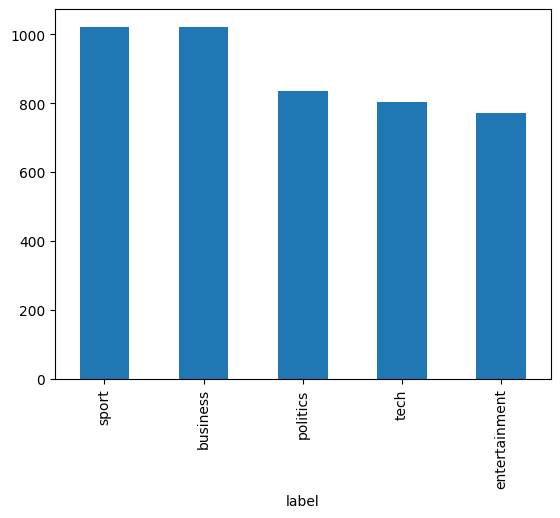

In [ ]:
# Pengencekan persebaran label di dataset
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

Dari bar plot yang kita bikin, dapat dilihat bahwa label entertainment mempunya data yang lebih sedikit dibanding label lain, namun perbedaan ini tidak terlalu besar, sehingga dinilai tidak akan menimbulkan masalah dalam melatih model


In [ ]:
#Mengubah target label dari string menjadi suatu bilangan bulat
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df

text  label
0       France have brought flanker Serge Betsen bac...      3
1       Carlos Moya described Spain's Davis Cup vict...      3
2       Second seed Andre Agassi suffered a comprehe...      3
3       Scotland manager Walter Smith has given his ...      3
4       Juninho's agent has confirmed that the playe...      3
...                                                 ...    ...
4445    A team of US researchers has shown that cont...      4
4446    Civil liberties group the Electronic Frontie...      4
4447    Mobile phones are still enjoying a boom time...      4
4448    First it was the humble home video, then it ...      4
4449    Robots are learning lessons on "robotiquette...      4

[4450 rows x 2 columns]

In [ ]:
import nltk
nltk.download('stopwords')
#Dilakukan pengunduhan kaus stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df

text  label
0     france brought flanker serge betsen back squad...      3
1     carlos moya described spains davis cup victory...      3
2     second seed andre agassi suffered comprehensiv...      3
3     scotland manager walter smith given backing re...      3
4     juninhos agent confirmed player hoping talks m...      3
...                                                 ...    ...
4445  team us researchers shown controlling devices ...      4
4446  civil liberties group electronic frontier foun...      4
4447  mobile phones still enjoying boom time sales a...      4
4448  first humble home video dvd hollywood preparin...      4
4449  robots learning lessons robotiquette behave so...      4

[4450 rows x 2 columns]

Kode ini membersihkan teks dengan mengonversinya ke huruf kecil, mengganti simbol tertentu dengan spasi, menghapus karakter yang tidak diinginkan, serta menghilangkan kata-kata umum (stopwords) dalam bahasa Inggris

In [ ]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [ ]:
df['text_split'] = df['text'].apply(get_split)
df

text  label  \
0     france brought flanker serge betsen back squad...      3   
1     carlos moya described spains davis cup victory...      3   
2     second seed andre agassi suffered comprehensiv...      3   
3     scotland manager walter smith given backing re...      3   
4     juninhos agent confirmed player hoping talks m...      3   
...                                                 ...    ...   
4445  team us researchers shown controlling devices ...      4   
4446  civil liberties group electronic frontier foun...      4   
4447  mobile phones still enjoying boom time sales a...      4   
4448  first humble home video dvd hollywood preparin...      4   
4449  robots learning lessons robotiquette behave so...      4   

                                             text_split  
0     [france brought flanker serge betsen back squa...  
1     [carlos moya described spains davis cup victor...  
2     [second seed andre agassi suffered comprehensi...  
3     [scotland manager walter smith given backing r...  
4     [juninhos agent confirmed player hoping talks ...  
...                                                 ...  
4445  [team us researchers shown controlling devices...  
4446  [civil liberties group electronic frontier fou...  
4447  [mobile phones still enjoying boom time sales ...  
4448  [first humble home video dvd hollywood prepari...  
4449  [robots learning lessons robotiquette behave s...  

[4450 rows x 3 columns]

Kode ini membagi teks menjadi beberapa bagian dengan panjang sekitar 200 kata, dengan overlap 50 kata antara bagian berturut-turut, dan menyimpannya dalam daftar

In [ ]:
# Dilakukan splitting data pelatihan dan validasti
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2)
train_texts


4248    television started magical blurry image came s...
2571    us open champion svetlana kuznetsova tested po...
579     police federation said strongly opposes giving...
3421    singapores economy grew 81 2004 best performan...
3660    german airline lufthansa may sue federal agenc...
                              ...                        
2552    ireland munster lock paul oconnell dismissed m...
4294    microsoft working new version internet explore...
3638    choking traffic jams beijing prompting officia...
3661    us economy grown expected expanding annual rat...
2838    tony blair chance tackle problems facing brita...
Name: text, Length: 3560, dtype: object

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)
train_encodings

{'input_ids': [[101, 2547, 2318, 8687, 14819, 2854, 3746, 2234, 4629, 2791, 6120, 2898, 18182, 4289, 2694, 2275, 2635, 2178, 11679, 2830, 6121, 3154, 2925, 2348, 2885, 5776, 2086, 12610, 2152, 3207, 16294, 22753, 2694, 10751, 9189, 2633, 2635, 9210, 3032, 2105, 2088, 3701, 2149, 2900, 2903, 1044, 18863, 10751, 9189, 10166, 2196, 2215, 2175, 2067, 2214, 2425, 2100, 10751, 9189, 6745, 2442, 3270, 3726, 2974, 7193, 5014, 2758, 8183, 13109, 4430, 15010, 3026, 11995, 6568, 2897, 2149, 2547, 4871, 2081, 27725, 2183, 2408, 3898, 13594, 3210, 2183, 2329, 2694, 4620, 2081, 22810, 3210, 6352, 27725, 5688, 10751, 9189, 4107, 1015, 5511, 2692, 3161, 3210, 2240, 2081, 1015, 6227, 2692, 27725, 2765, 3861, 2416, 2335, 4629, 3115, 2694, 2131, 2440, 4254, 8497, 2342, 3743, 4289, 2342, 10751, 9189, 2275, 102], [101, 2149, 2330, 3410, 17917, 3388, 16695, 13970, 2480, 22781, 7103, 7718, 3893, 7917, 4319, 2429, 6995, 4614, 6995, 2998, 2704, 8149, 25212, 25547, 7520, 2015, 2056, 2845, 2088, 2193, 2274, 7718

Kode ini menggunakan BertTokenizer dari model 'bert-base-uncased' untuk mengubah teks pelatihan (train_texts) dan validasi (val_texts) menjadi token yang siap digunakan sebagai input untuk model BERT.

*   truncation=True memastikan teks yang lebih panjang dari 128 token akan dipotong.
*   padding=True menambahkan padding agar semua input memiliki panjang yang sama.
*   max_length=128 membatasi panjang maksimum setiap teks menjadi 128 token



In [ ]:
import torch
import wandb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Using device: cpu


Kode ini membuat custom PyTorch Dataset untuk teks yang telah dikodekan dengan tokenizer BERT, di mana setiap sampel dikonversi menjadi tensor, termasuk token dan labelnya, sehingga dapat digunakan dalam DataLoader PyTorch untuk pelatihan dan validasi.


*   torch dan torch.utils.data.Dataset digunakan untuk membuat dataset PyTorch.
*   __init__: Menerima encodings (hasil tokenisasi teks) dan labels (label kelas).  
*    __getitem__:
Mengambil data pada indeks tertentu (idx).
Mengonversi setiap nilai dalam encodings menjadi tensor PyTorch.
Menambahkan label ('labels') ke dalam item.
*   __len__:Mengembalikan jumlah sampel dalam dataset.






model loading

In [ ]:
len(np.unique(train_labels))

5

In [ ]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(np.unique(train_labels))
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df.label.unique()

array([1, 0, 3, 4, 2])

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42
)
X_train

4250    gordon brown outlined thinks key themes new la...
4283    tony blair chance tackle problems facing brita...
4264    umpteenth time tony blair gordon brown said de...
1222    england prop phil vickery staying positive des...
353     us comedian bill cosby face charges stemming a...
                              ...                        
4426    plans allow foreign nuclear waste permanently ...
466     growth japan evaporated three months september...
3092    economic targets set lisbon summit european un...
3772    growth mobile phone market past decade nothing...
860     us defence telecommunications company agreed p...
Name: text, Length: 3560, dtype: object

In [ ]:
# Create datasets and dataloaders
train_dataset = TextClassificationDataset(X_train, y_train, tokenizer)
val_dataset = TextClassificationDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Optimizer and scaler for mixed precision training
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Detailed error checking function
def debug_dataframe(df, x_col='text', y_col='label'):
    print("DataFrame Information:")
    print(f"Total rows: {len(df)}")
    print(f"\nColumn names: {list(df.columns)}")

    print("\nColumn types:")
    print(df.dtypes)

    print("\nUnique labels:")
    print(df[y_col].unique())

    print("\nLabel value counts:")
    print(df[y_col].value_counts())

    print("\nChecking for missing values:")
    print(df.isnull().sum())

    print("\nSample data:")
    display(df.head())

debug_dataframe(df)

DataFrame Information:
Total rows: 4450

Column names: ['text', 'label', 'text_split']

Column types:
text          object
label          int64
text_split    object
dtype: object

Unique labels:
[1 0 3 4 2]

Label value counts:
label
3    1022
0    1020
2     834
4     802
1     772
Name: count, dtype: int64

Checking for missing values:
text          0
label         0
text_split    0
dtype: int64

Sample data:


text  label  \
0  sixth final star wars movie may suitable young...      1   
1  oscarwinning director hayao miyazakis latest f...      1   
2  martin scorsese clint eastwood among nominees ...      1   
3  fans buy tickets years glastonbury festival is...      1   
4  reporters covering singer michael jacksons tri...      1   

                                          text_split  
0  [sixth final star wars movie may suitable youn...  
1  [oscarwinning director hayao miyazakis latest ...  
2  [martin scorsese clint eastwood among nominees...  
3  [fans buy tickets years glastonbury festival i...  
4  [reporters covering singer michael jacksons tr...

In [ ]:
# Initialize WandB
wandb.init(project="bert-document-classification", config={
    "batch_size": 16,
    "epochs": 4,
    "learning_rate": 2e-5,
    "max_length": 256
})

# Optimizer
optimizer = AdamW(model.parameters(), lr=wandb.config.learning_rate)
# Training loop
for epoch in range(5):
    model.train()
    train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    # Log metrics to wandb
    wandb.log({
        "train_loss": train_loss / len(train_loader),
        "val_loss": val_loss / len(val_loader),
        "val_accuracy": correct_preds / total_preds
    })

    print(f"Epoch {epoch + 1}/{wandb.config.epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {correct_preds / total_preds}")

# Save model and finish wandb run
torch.save(model.state_dict(), 'bert_document_classifier.pth')
wandb.finish()

KeyError: 1170

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import wandb

# Custom Dataset Class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize WandB
wandb.init(project="bert-document-classification", config={
    "batch_size": 16,
    "epochs": 10,
    "learning_rate": 2e-5,
    "max_length": 256
})

texts = df['text'].values
labels = df['label'].values

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create dataset
dataset = TextClassificationDataset(
    texts=texts,
    labels=labels,
    tokenizer=tokenizer,
    max_length=wandb.config.max_length
)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=wandb.config.batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=wandb.config.batch_size,
    shuffle=False
)

# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(np.unique(labels))
).to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=wandb.config.learning_rate)

# Training loop
for epoch in range(wandb.config.epochs):
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in val_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct = (preds == labels).sum().item()
        total_eval_accuracy += correct / len(batch['labels'])

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Log to WandB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": avg_val_accuracy
    })

    print(f"Epoch {epoch + 1}")
    print(f"Train loss: {avg_train_loss:.4f}")
    print(f"Val loss: {avg_val_loss:.4f}")
    print(f"Val accuracy: {avg_val_accuracy:.4f}")

# Save model
model.save_pretrained("./bert_classifier")
tokenizer.save_pretrained("./bert_classifier")

# Finish WandB
wandb.finish()

Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hilmy-rahmadani to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
Train loss: 0.3177
Val loss: 0.0650
Val accuracy: 0.9888
Epoch 2
Train loss: 0.0337
Val loss: 0.0286
Val accuracy: 0.9944
Epoch 3
Train loss: 0.0088
Val loss: 0.0243
Val accuracy: 0.9967
Epoch 4
Train loss: 0.0008
Val loss: 0.0202
Val accuracy: 0.9978
Epoch 5
Train loss: 0.0005
Val loss: 0.0216
Val accuracy: 0.9978
Epoch 6
Train loss: 0.0004
Val loss: 0.0223
Val accuracy: 0.9978
Epoch 7
Train loss: 0.0003
Val loss: 0.0228
Val accuracy: 0.9978
Epoch 8
Train loss: 0.0002
Val loss: 0.0232
Val accuracy: 0.9978
Epoch 9
Train loss: 0.0002
Val loss: 0.0238
Val accuracy: 0.9978
Epoch 10
Train loss: 0.0001
Val loss: 0.0242
Val accuracy: 0.9978


In [ ]:
epoch	10
train_loss	0.00015
val_accuracy	0.99777
val_loss	0.02421

2
